In [1]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
from torchvision import models, transforms as T
import torchvision.transforms.functional as F
import numpy as np
import os
from pathlib import Path
from patchify import patchify, unpatchify
import matplotlib.pyplot as plt
import nbimporter
from patches import read_and_patch_images
import visualization
import weights
# from visualization import show, show_grid, mask_images

In [2]:
voc_dir = 'C:/Users/Hayden/Machine Learning/d2l/d2l-en/pytorch/chapter_computer-vision/data/VOCdevkit/VOC2012/'

In [35]:
# class VocDataset_old(Dataset):
#     '''Dataset that pre-loads the PASCAL2 VOC 2012 dataset into RAM. This implies that the DataLoader must have num_workers=0. The argument "transforms" must be a transformation ending with ToTensor.'''
#     def __init__(self, data_dir, transforms, dataset_type):
#         self.data_dir = data_dir
#         self.transforms = transforms
#         self.dataset_type = dataset_type
#         self.normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#         self.images, self.masks = self.load_images()

#     def load_images(self):
#         images, masks = read_and_patch_images(self.data_dir, self.dataset_type)
#         # images, masks = torch.from_numpy(images), torch.from_numpy(masks)
#         images = images.squeeze(1)
#         masks = masks.squeeze(1)

#         # my_stack = torch.empty(0)
#         # for image in images:
#         #     print('transforms')
#         #     new_image = self.transforms(image).to(torch.float32)
#         #     print('normalize')
#         #     norm_image = self.normalize(new_image)
#         #     print('stack')
#         #     my_stack = torch.stack((my_stack, norm_image))
#         images = torch.stack([
#             self.normalize(self.transforms(image).to(torch.float32))
#             for image in images
#         ])
#         masks = torch.stack([
#             self.transforms(mask).to(torch.float32)
#             for mask in masks
#         ])
#         print('TENSOR', images.shape, type(images), type(images[0]), type(images[0][0]), type(images[0][0][0]))
        
#         return images, masks

#     def __len__(self):
#         return len(self.images)

#     def __getitem__(self, index):
#         return self.images[index], self.masks[index]

# # transforms = torchvision.transforms.ToTensor()
# transforms = T.Compose([
#     # T.RandomHorizontalFlip(),
#     # T.RandomVerticalFlip(),
#     T.ToTensor()
# ])
# train_set = VocDataset_old(voc_dir, transforms, 'train')

In [36]:
# train_iter = torch.utils.data.DataLoader(train_set, 256, shuffle=True, drop_last=True, num_workers=0)
# # import nbimporter
# # import utils

# # DATA_DIR = 'C:/Users/Hayden/Machine Learning/d2l/d2l-en/pytorch/chapter_computer-vision/data/VOCdevkit/VOC2012/'
# # BATCH_SIZE=16
# # train_transform = T.Compose([
# #     T.RandomHorizontalFlip(),
# #     T.RandomVerticalFlip(),
# #     T.ToTensor()
# # ])
# # validation_transform = T.Compose([
# #     T.ToTensor()
# # ])
# # test_transform = T.Compose([
# #     T.ToTensor()
# # ])
# # train_loader, validation_loader, test_loader = utils.get_data_loaders(
# #     data_dir=DATA_DIR,
# #     train_transforms=train_transform,
# #     validation_transforms=validation_transform,
# #     test_transforms=test_transform,
# #     batch_size=BATCH_SIZE,
# # )
# # train_iter, val_iter, test_iter = utils.get_data_loaders(DATA_DIR, train_transform, validation_transform, test_transform, BATCH_SIZE)

# print('Total number of batches:', len(train_iter))
# for X, Y in train_iter:
#     print('X shape:', X.shape)
#     print('Y shape:', Y.shape)
#     print(type(X))
#     break

In [3]:
class VocDataset(Dataset):
    def __init__(self, data_dir, image_transform, mask_transform, crop_size, dataset):
        '''dataset must be a string of the following: "train", "trainval", "val" or "test".
        crop_size expects (width, height)'''
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.crop_size = crop_size
        self.dataset = dataset
        self.normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        self.data_paths = self.get_data_paths(data_dir, dataset)

    def get_data_paths(self, data_dir, dataset):
        '''Returns a list of tuples containing the path to the images, their respective masks and weight maps for all images greater than self.crop_size.'''
        annotations_file = os.path.join(data_dir, 'ImageSets', 'Segmentation', dataset+'.txt')

        with open(annotations_file, 'r') as f:
            file_names = f.read().split()
        
        paths = []
        for file_name in file_names:
            image_path = os.path.join(data_dir, 'JPEGImages', f'{file_name}.jpg')
            with Image.open(image_path) as img:
                width, height = img.size
            if width >= self.crop_size[0] and height >= self.crop_size[1]:
                mask_path = os.path.join(data_dir, 'SegmentationClass', f'{file_name}.png')
                weight_path = os.path.join(data_dir, 'SegmentationWeights', f'{file_name}.npy')
                paths.append((image_path, mask_path, weight_path))
        
        return paths
    
    def load_data(self, image_path, mask_path=None, weight_path=None):
        image = Image.open(image_path)
        if mask_path is not None:
            mask = Image.open(mask_path)
            weight_map = weights.load_weight_map(weight_path)
            # weight_map = weights.load_weight_map(weight_path, Path(mask_path).stem)
            # print(image.shape, mask.shape)
            return Path(image_path), image, Path(mask_path), mask, Path(weight_path) ,weight_map
        return Path(image_path).name, image

    def remove_outline(self, mask, outline=0):
        '''Converts the outline (any value of 255) in a mask tensor to a specified value.'''
        mask[mask == 255] = outline
        return mask
    
    def __len__(self):
        return len(self.data_paths)

    # def __getitem__(self, index):
    #     image_path, mask_path = self.data_paths[index]
    #     image = Image.open(image_path)
        
    #     crop_params = T.RandomCrop(self.crop_size).get_params(image, self.crop_size)
    #     image = F.crop(image, *crop_params)
    #     image = self.normalize(self.image_transform(image)).float()

    #     if self.dataset == 'test':
    #         return image

    #     mask = Image.open(mask_path)
    #     mask = F.crop(mask, *crop_params)
    #     mask = T.PILToTensor()(mask).squeeze(0).long()
    #     return image, mask

    
    def __getitem__(self, index):
        image_path = self.data_paths[index][0]
        if self.dataset != 'test':
            mask_path = self.data_paths[index][1]
            weight_path = self.data_paths[index][2]
            # print('weight:', weight_path)
            image_path, image, mask_path, mask, weight_path, weight_map = self.load_data(image_path, mask_path, weight_path)
        else:
            image_path, image = self.load_data(image_path)

        crop_params = T.RandomCrop(self.crop_size).get_params(image, self.crop_size)
        image = F.crop(image, *crop_params)
        image = self.normalize(self.image_transform(image)).to(torch.float32)

        # totensor = T.ToTensor()
        # image = totensor(image)
        # mask = totensor(mask)
        if self.dataset != 'test':
            mask = F.crop(mask, *crop_params)
            # mask = T.PILToTensor()(mask).squeeze(0).long()
            mask = T.PILToTensor()(mask)
            # mask = self.mask_transform(mask).to(torch.float32)
            mask = self.remove_outline(mask)
            # mask = self.mask_transform(mask)

            # weight_map = F.crop(Image.fromarray(weight_map), *crop_params)
            # weight_map = T.PILToTensor()(weight_map)
            top, left, height, width = crop_params
            weight_map = weight_map[top:top+height, left:left+width]
            weight_map = torch.from_numpy(weight_map).float()
            # print(image_path, mask_path, weight_path, sep='\n')
            # return image, mask, weight_map
            return {
                'image_path': str(image_path),
                'image': image,
                'mask_path': str(mask_path),
                'mask': mask,
                'weight_path': str(weight_path),
                'weight_map': weight_map
            }
        
        return image

In [4]:
# ImageNet normalization values
image_transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor()
    # T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# For masks (don't normalize, keep as long tensors)
mask_transform = T.Compose([
    T.Resize((256, 256), interpolation=Image.NEAREST),
    T.PILToTensor(),  # Output shape: [1, H, W]
    # T.Lambda(lambda x: x.squeeze(0).long())  # convert to shape: [H, W]
    T.Lambda(lambda x: torch.from_numpy(np.array(x)).long())
])

from torch.utils.data import DataLoader

# Assuming VOC2012 is in ./VOCdevkit/VOC2012
dataset = VocDataset(
    data_dir=voc_dir,
    image_transform=image_transform,
    mask_transform=mask_transform,
    crop_size=(256, 256),
    dataset='train'
)

dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2007_000648.npy
DONE


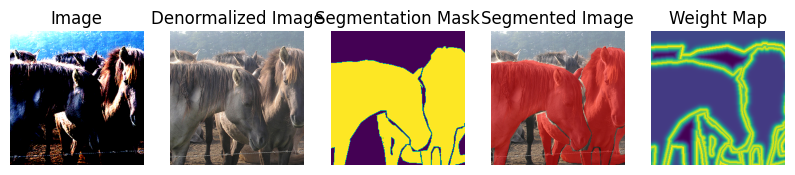

In [220]:
import matplotlib.pyplot as plt
import numpy as np

def denormalize(img_tensor):
    """Undo ImageNet normalization for visualization"""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = img_tensor * std + mean
    return img.clamp(0, 1)

nxt = next(iter(dataloader))
print(Path(nxt['weight_path'][0]).name)


# View a batch
for nxt in dataloader:
    
    print('DONE')

    img = nxt['image'][0].permute(1, 2, 0).numpy()
    mask = nxt['mask'][0].permute(1, 2, 0).numpy().astype('int64')
    weight_map = nxt['weight_map'].permute(1, 2, 0).numpy()

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 5, 1)
    plt.imshow(img)
    plt.title("Image")
    plt.axis('off')

    image = denormalize(nxt['image'][0]).permute(1, 2, 0).numpy()
    plt.subplot(1, 5, 2)
    plt.imshow(image)
    plt.title("Denormalized Image")
    plt.axis('off')
    
    plt.subplot(1, 5, 3)
    plt.imshow(mask)
    plt.title("Segmentation Mask")
    plt.axis('off')

    masked_pixels = nxt['mask'][0] != torch.zeros_like(nxt['mask'][0])
    masked_image = torchvision.utils.draw_segmentation_masks((torch.from_numpy(image)*255).clamp(0, 255).permute(2, 0, 1).to(torch.uint8), masked_pixels, alpha=0.5, colors=(255, 0, 0))
    # masked_image = torchvision.utils.draw_segmentation_masks(images[0].to(torch.uint8), masked_pixels, 0.6, (0, 128, 128))
    plt.subplot(1, 5, 4)
    plt.imshow(masked_image.permute(1, 2, 0))
    plt.title("Segmented Image")
    plt.axis('off')

    plt.subplot(1, 5, 5)
    plt.imshow(weight_map)
    plt.title('Weight Map')
    plt.axis('off')

    plt.show()
    break


In [59]:
def get_data_loader(data_dir, image_transform, mask_transform, crop_size, dataset, batch_size):
    '''dataset must be one of the following: "train", "val" or "test"'''
    set = VocDataset(data_dir, image_transform, mask_transform, crop_size, dataset)
    print(len(set))
    loader = DataLoader(set, batch_size, shuffle=False, num_workers=0, drop_last=True)
    return loader

In [41]:
train_loader = get_data_loader(voc_dir, T.ToTensor(), T.ToTensor(), (256, 256), 'train', 8)
X, y = next(iter(train_loader))
print(X.shape, X.dtype)  # should be [B, 3, H, W], float32
print(y.shape, y.dtype)  # should be [B, H, W], long
print(y.unique())        # should be in 0..20 (and possibly 255)


1444
torch.Size([8, 3, 256, 256]) torch.float32
torch.Size([8, 1, 256, 256]) torch.uint8
tensor([ 0,  1,  3,  4,  5,  9, 12, 15, 20], dtype=torch.uint8)


In [68]:
crop_size = (256, 256)
# crop_size = (100, 100)
# crop_size = (128, 128)
transform = T.ToTensor()
train_loader = get_data_loader(voc_dir, transform, transform, crop_size, 'train', 8)

1444


In [69]:
for image, mask in train_loader:
    print(image.shape)
    print(mask.shape)
    # visualization.show(image)
    # visualization.show(mask)
    break

torch.Size([8, 3, 256, 256])
torch.Size([8, 1, 256, 256])


In [70]:
VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]

In [4]:
def denormalize_(tensor, mean=torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1), std=torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

def denormalize(img_tensor):
    """Undo ImageNet normalization for visualization"""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = img_tensor * std + mean
    return img.clamp(0, 1)


In [ ]:
# from visualization import show, show_grid, mask_images
# import visualization


# def display_images_masks(images, masks, denorm_fn):
#     '''TODO: INCOMPLETE IMPLEMENTATION OF THE BELOW CODE.'''
#     length = len(images)
#     if length != len(masks):
#         print(f'The length of images ({len(images)}) must be equivalent to the length of masks ({len(masks)}).')
#         raise IndexError()
#     visualization.show_grid([image for image in images], length)
#     visualization.show_grid([denorm_fn(image) for image in images], length)
#     visualization.show_grid([mask for mask in masks], length)
#     visualization.show_grid(visualization.mask_images(images, masks, 0.4, 'purple'), length)

for images, masks in train_loader:
    for image in images:
        print(f'min={torch.min(image)}, max={torch.max(image)}')
    print(images[0].shape, masks[0].shape)
    visualization.show_grid([image for image in images], 8)
    visualization.show_grid([denormalize(image) for image in images], 8)
    visualization.show_grid([mask for mask in masks], 8)
    # for image, mask in zip(images, masks):
    #     image.to(torch.uint8)
    #     mask.to(torch.uint8)
    for image in range(len(images)):
        images[image] = denormalize(images[image])
    images = (images * 255).clamp(0, 255).to(torch.uint8)
    masks = masks != 0
    # masks = masks.to(torch.uint8)
    visualization.show_grid(visualization.mask_images(images, masks, 0.4, 'purple'), 8)
    break

NameError: name 'train_loader' is not defined

background aeroplane person
mask.shape=torch.Size([1, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 256, 3, 256])


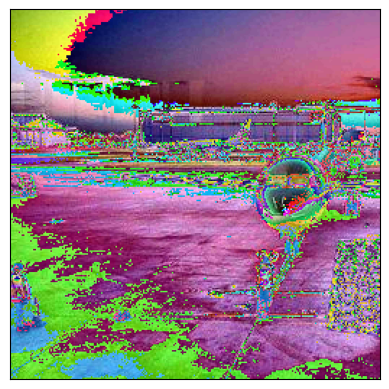

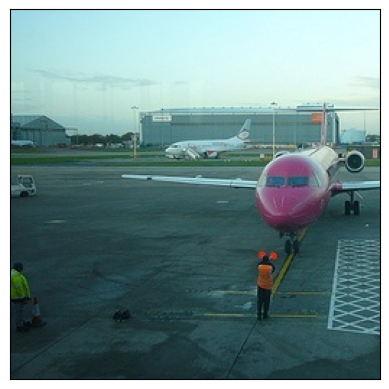

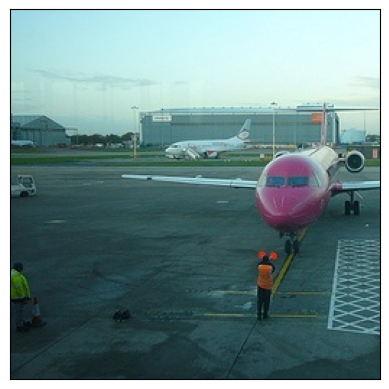

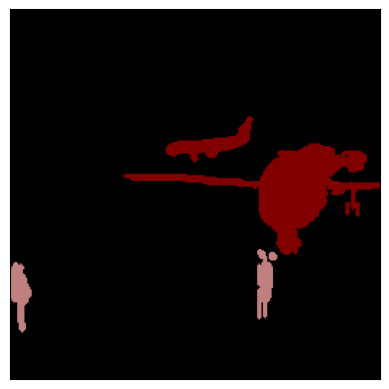

In [ ]:
def remove_outline(mask, outline=0):
    '''Converts the outline (any value of 255) in a mask tensor to a specified value.'''
    mask[mask == 255] = outline
    return mask

def classes_in_mask(mask, dataset_classes):
    '''
    Returns a list of all the classes in the mask. The mask should not contain a value of 255 in it. Use remove_outline() to convert before using this method.
    mask must be of shape tensor.Size([N, C, H, W])
    dataset_classes must be a list of classes. Likely represented by a string.
    '''
    class_indices = torch.unique(mask).tolist()
    if len(class_indices) > 21:
        print(f'Class indices is expected to contain 21 elements, got {len(class_indices)}.\n\tclass_in_mask() is not implemented to handle an additional class for the mask outline.\n\tIt is likely that the mask implements a class for the outline.')
        raise NotImplementedError()
    return [dataset_classes[idx] for idx in class_indices]

def mask_to_image(mask, colour_map):
    '''Converts the mask to an image based on the colour map. Expects that all values in the mask are in the range 0 to len(colour_map). Can be of shape [N,C,H,W] or [C,H,W]'''
    # print(f'mask.shape={mask.shape}')
    image = torch.tensor(colour_map)[mask.long()]
    return image.permute(0, 3, 1, 2).byte()

image, mask = VocDataset(voc_dir, transform, transform, crop_size, 'train')[0]

print(*classes_in_mask(remove_outline(mask), VOC_CLASSES))
visualization.show(image)
visualization.show(denormalize(image))
visualization.show(denormalize_(image))
mask = remove_outline(mask)
mask = mask_to_image(mask, VOC_COLORMAP)
print(mask.shape)
print(mask.permute(0, 3, 1, 2).shape)
visualization.show(mask.squeeze(0).byte())
# visualization.show(mask.permute(0, 3, 1, 2).squeeze(0).byte())

torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([21, 3])
torch.Size([1, 256, 256])


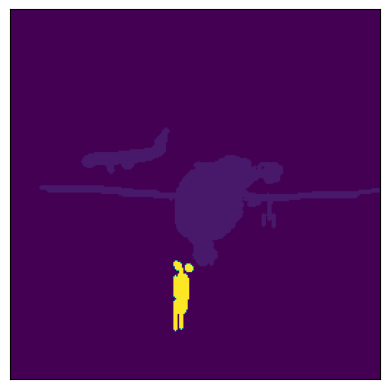

In [47]:
transform = T.ToTensor()
test_set = VocDataset(voc_dir, transform, transform, (256, 256), 'train')
# print(test_set[1].shape)
# print(test_set[1].dtype)
image, mask = test_set[0]
print(image.shape)
print(mask.shape)
visualization.show(mask)
cmap = torch.tensor(VOC_COLORMAP)
print(cmap.shape)
print(mask.shape)
# classes = torch.tensor(VOC_CLASSES)
# rgb_image = cmap[mask]


background aeroplane person
mask.shape=torch.Size([1, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 256, 3, 256])


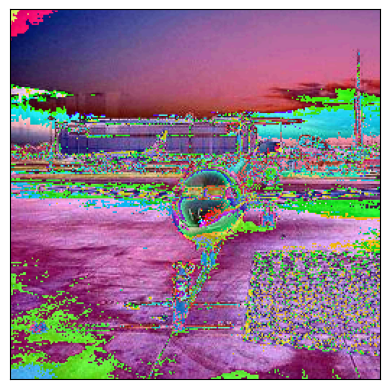

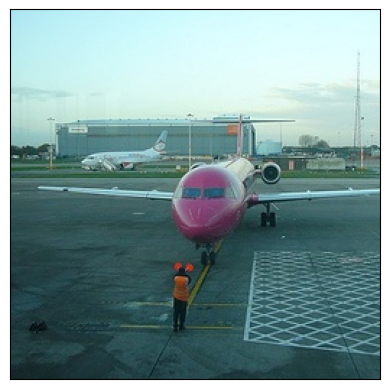

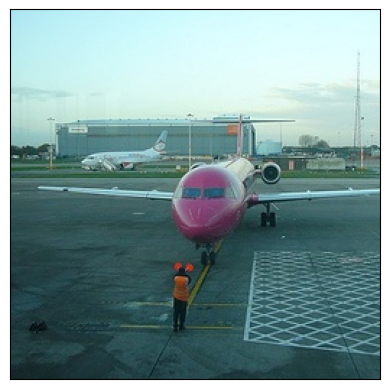

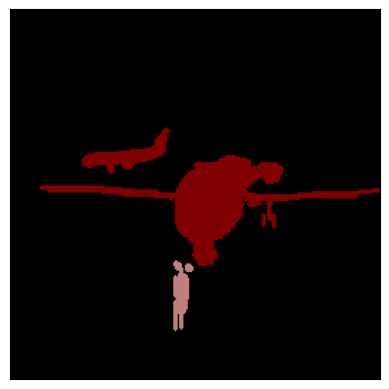

In [48]:
print(*classes_in_mask(remove_outline(mask), VOC_CLASSES))
visualization.show(image)
visualization.show(denormalize(image))
visualization.show(denormalize_(image))
mask = remove_outline(mask)
mask = mask_to_image(mask, VOC_COLORMAP)
print(mask.shape)
print(mask.permute(0, 3, 1, 2).shape)
visualization.show(mask.squeeze(0).byte())

In [49]:
crop_size = (500, 500)
transform = T.ToTensor()
ds = VocDataset(voc_dir, transform, transform, crop_size, 'train')
print(len(ds))

7


In [62]:
import os
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as T
import torchvision.transforms.functional as F
import torch


class VocAeroplane(Dataset):
    def __init__(self, data_dir, crop_size=(320, 320), dataset="train", class_filter="airplane"):
        """
        Args:
            data_dir (str): Path to Pascal VOC root (VOC2012 directory).
            crop_size (tuple): Crop size (width, height).
            dataset (str): One of ['train', 'val', 'trainval', 'test'].
            class_filter (str): Pascal VOC class to filter for (e.g., 'aeroplane').
        """
        assert dataset in ["train", "val", "trainval", "test"], f"Invalid dataset split: {dataset}"
        self.data_dir = data_dir
        self.crop_size = crop_size
        self.dataset = dataset
        self.is_test = dataset == "test"
        self.class_filter = class_filter

        # Image transform
        self.image_transform = T.Compose([
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        # Mask transform
        self.mask_transform = T.Compose([
            T.PILToTensor(),
            T.Lambda(lambda x: x.squeeze(0).long())
        ])

        self.random_crop = T.RandomCrop(self.crop_size)

        self.data_paths = self.get_filtered_paths()

    def get_filtered_paths(self):
        """Filter and return only image/mask paths that contain the target class."""
        main_dir = os.path.join(self.data_dir, "ImageSets", "Main")
        class_file = os.path.join(main_dir, f"{self.class_filter}_{self.dataset}.txt")
        segmentation_dir = os.path.join(self.data_dir, "SegmentationClass")
        image_dir = os.path.join(self.data_dir, "JPEGImages")

        if not os.path.exists(class_file):
            raise FileNotFoundError(f"Missing class label file: {class_file}")

        paths = []
        with open(class_file, 'r') as f:
            for line in f:
                name, label = line.strip().split()
                if int(label) == 1:
                    image_path = os.path.join(image_dir, f"{name}.jpg")
                    mask_path = os.path.join(segmentation_dir, f"{name}.png")
                    if not os.path.exists(image_path) or (not self.is_test and not os.path.exists(mask_path)):
                        continue
                    with Image.open(image_path) as img:
                        if img.width >= self.crop_size[0] and img.height >= self.crop_size[1]:
                            paths.append((image_path, mask_path if not self.is_test else None))
        return paths

    def remove_outline(self, mask, outline=0):
        """Convert VOC mask outline class 255 to specified class (usually background)."""
        mask[mask == 255] = outline
        return mask

    def __len__(self):
        return len(self.data_paths)

    def __getitem__(self, index):
        image_path, mask_path = self.data_paths[index]
        image = Image.open(image_path).convert("RGB")

        i, j, h, w = self.random_crop.get_params(image, self.crop_size)
        image = F.crop(image, i, j, h, w)
        image = self.image_transform(image)

        if not self.is_test:
            mask = Image.open(mask_path).convert("P")
            mask = F.crop(mask, i, j, h, w)
            mask = self.mask_transform(mask)
            mask = self.remove_outline(mask)
            return image, mask

        return image


In [63]:
dataset = VocAeroplane(
    data_dir=voc_dir,
    crop_size=(320, 320),
    dataset="train",
    class_filter="aeroplane"
)

img, mask = dataset[6]
print(img.shape, mask.shape)


torch.Size([3, 320, 320]) torch.Size([320, 320])


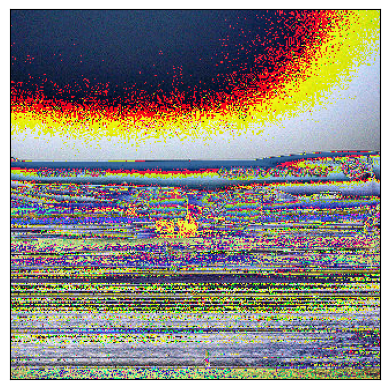

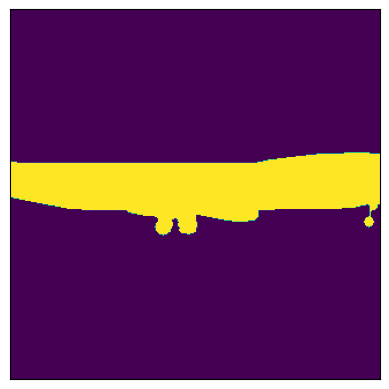

In [64]:
visualization.show(img)
visualization.show(mask.to(torch.uint8))

In [5]:
import numpy as np
from scipy.ndimage import distance_transform_edt
from skimage.measure import label

def compute_weight_map(mask: np.ndarray, w0=10, sigma=5) -> np.ndarray:
    """
    Compute the U-Net weight map for a given binary instance segmentation mask.

    Parameters:
        mask: np.ndarray
            An (H, W) array where each object instance has a unique integer label.
            Background should be 0.
        w0: float
            Weight coefficient for the border term.
        sigma: float
            Controls decay of border term.

    Returns:
        weight_map: np.ndarray
            A (H, W) weight map as described in the U-Net paper.
    """
    # Class balancing term: inverse frequency
    labels, counts = np.unique(mask, return_counts=True)
    total_pixels = np.sum(counts)
    class_weights = {label: total_pixels / count for label, count in zip(labels, counts)}

    wc = np.zeros_like(mask, dtype=np.float32)
    for label_val in labels:
        wc[mask == label_val] = class_weights[label_val]

    # If only one object or none: skip border weighting
    if len(labels) <= 2:
        return wc

    # Create binary masks for each object (excluding background)
    object_masks = [(mask == label_id).astype(np.uint8) for label_id in labels if label_id != 0]

    # Compute distance maps
    dists = np.array([distance_transform_edt(1 - obj) for obj in object_masks])
    dists = np.sort(dists, axis=0)  # sort along object axis

    d1 = dists[0]  # closest object
    d2 = dists[1]  # second closest object

    # Compute border weight
    border_term = w0 * np.exp(- ((d1 + d2) ** 2) / (2 * sigma ** 2))

    return wc + border_term

In [6]:
import numpy as np
from scipy.ndimage import distance_transform_edt, binary_erosion
from skimage.segmentation import find_boundaries

def compute_weight_map_multiclass(mask: np.ndarray, num_classes: int, w0=10, sigma=5) -> np.ndarray:
    """
    Computes U-Net weight map for multi-class segmentation.

    Parameters:
        mask: (H, W) np.ndarray with class labels (0 to num_classes - 1)
        num_classes: Total number of semantic classes
        w0: Border weight coefficient
        sigma: Controls border decay

    Returns:
        weight_map: (H, W) np.ndarray
    """

    H, W = mask.shape

    # Step 1: Class balancing weight wc(x)
    wc = np.zeros_like(mask, dtype=np.float32)
    class_weights = {}
    total_pixels = H * W

    for cls in range(num_classes):
        cls_mask = (mask == cls)
        count = np.sum(cls_mask)
        if count > 0:
            class_weights[cls] = total_pixels / count
            wc[cls_mask] = class_weights[cls]
        else:
            class_weights[cls] = 0

    # Step 2: Border term (distance to class boundaries)
    # Find boundaries between semantic regions
    boundaries = find_boundaries(mask, mode='thick').astype(np.uint8)

    # Invert boundaries to get non-boundary regions for distance transform
    non_boundary = 1 - boundaries

    # Compute distance to nearest boundary for all pixels
    dist_to_boundary = distance_transform_edt(non_boundary)

    # Simulate (d1 + d2) using distance to boundary from both sides
    border_term = w0 * np.exp(- (dist_to_boundary ** 2) / (2 * sigma ** 2))

    # Final weight map
    weight_map = wc + border_term
    return weight_map


In [14]:
import numpy as np
from scipy.ndimage import distance_transform_edt
from skimage.segmentation import find_boundaries

def compute_weight_map_multiclass_changed(mask: np.ndarray, num_classes: int, w0=10, sigma=5) -> np.ndarray:
    """
    Compute a more numerically stable U-Net-style weight map for multi-class segmentation.

    Args:
        mask (np.ndarray): (H, W) array with class labels (0 to num_classes - 1)
        num_classes (int): Number of semantic classes
        w0 (float): Border weight coefficient
        sigma (float): Border falloff (Gaussian scale)

    Returns:
        np.ndarray: Weight map of shape (H, W)
    """
    H, W = mask.shape

    # 1. Compute class frequencies across this mask
    class_weights = np.zeros(num_classes, dtype=np.float32)
    total_pixels = H * W
    for cls in range(num_classes):
        freq = np.sum(mask == cls)
        if freq > 0:
            class_weights[cls] = total_pixels / (num_classes * freq)  # normalized inverse frequency

    # Apply class weights to pixels
    wc = np.zeros((H, W), dtype=np.float32)
    for cls in range(num_classes):
        wc[mask == cls] = class_weights[cls]

    # 2. Compute border term
    boundaries = find_boundaries(mask, mode='thick').astype(np.uint8)
    dist_to_border = distance_transform_edt(1 - boundaries)

    border_term = w0 * np.exp(- (dist_to_border ** 2) / (2 * (sigma ** 2)))

    # 3. Combine terms
    weight_map = wc + border_term
    
    return wc, border_term, weight_map


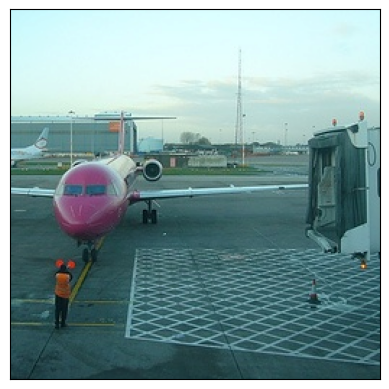

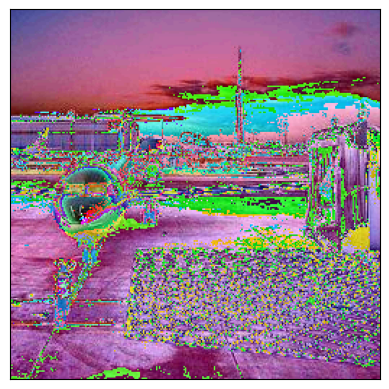

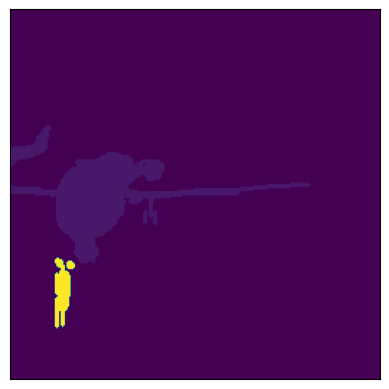

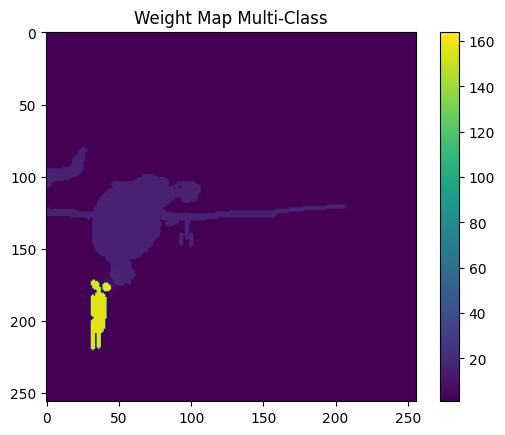

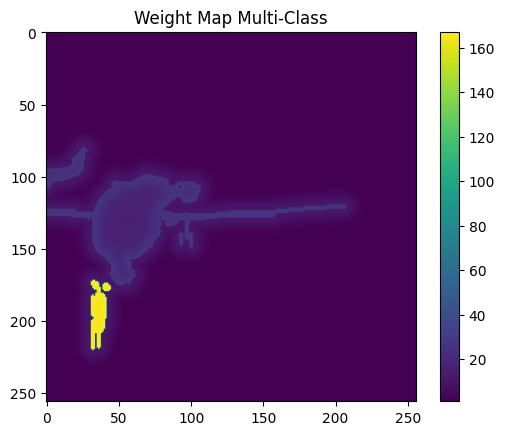

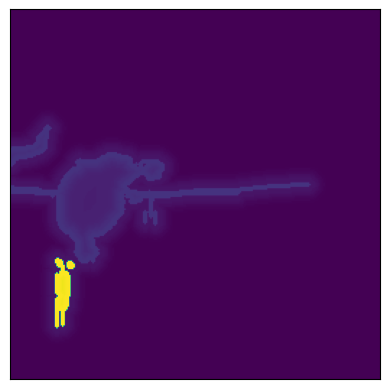

9.426693055160388
1.0739909410476685


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import albumentations as A
import nbimporter
from carvana import CarvanaDataset

# Suppose your instance mask has objects labeled as 1, 2, 3, ...
# mask = np.array(Image.open("instance_mask.png"))  # shape (H, W), with instance labels
# transform = A.ToTensorV2()
transform = T.ToTensor()
crop_size = (256, 256)
image_dir = 'D:/machine-learning/datasets/carvana/train'
mask_dir = 'D:/machine-learning/datasets/carvana/train_masks'

dataset = CarvanaDataset(image_dir, mask_dir, transform)
dataset = VocDataset(voc_dir, transform, transform, crop_size, 'train')
image, mask = dataset[0]
visualization.show(denormalize(image))
visualization.show(image)
visualization.show(mask)

weight_map = compute_weight_map(np.array(mask.squeeze()))
plt.imshow(weight_map, cmap='viridis')
plt.colorbar()
plt.title("Weight Map Multi-Class")
plt.show()
# visualization.show(torch.from_numpy(weight_map))

weight_map = compute_weight_map_multiclass(np.array(mask.squeeze()), 21)


plt.imshow(weight_map, cmap='viridis')
plt.colorbar()
plt.title("Weight Map Multi-Class")
plt.show()
visualization.show(torch.from_numpy(weight_map).to(torch.uint8))

print(weight_map[100][100])
print(weight_map[10][10])


In [57]:
print(np.max(weight_map))
print(np.min(weight_map))
print(np.max(weight_map[200]))
print(weight_map[250][100])
print(weight_map[250][250])

15.797080993652344
1.2084600925445557
15.797080993652344
5.797082288114973
1.2084600925445557


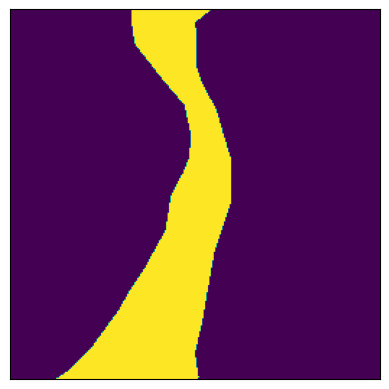

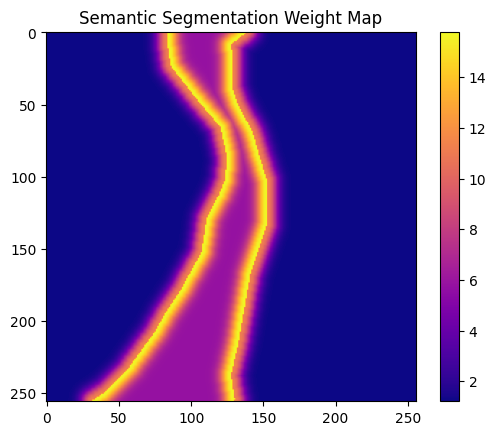

In [58]:
mask = np.array(mask.squeeze())  # shape: (H, W), labels in [0, num_classes-1]
weight_map = compute_weight_map_multiclass(mask, num_classes=21, w0=10, sigma=5)
visualization.show(mask)
plt.imshow(weight_map, cmap='plasma')
plt.colorbar()
plt.title("Semantic Segmentation Weight Map")
plt.show()


In [59]:
print(np.min(weight_map), np.max(weight_map))
print(mask.shape)
print(weight_map.shape)
print(weight_map[200][10])
print(weight_map[200][100])

1.2084600925445557 15.797080993652344
(256, 256)
(256, 256)
1.2084600925445557
5.823932995421882


(256, 256)


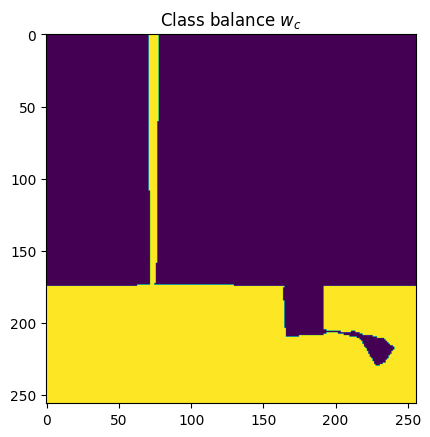

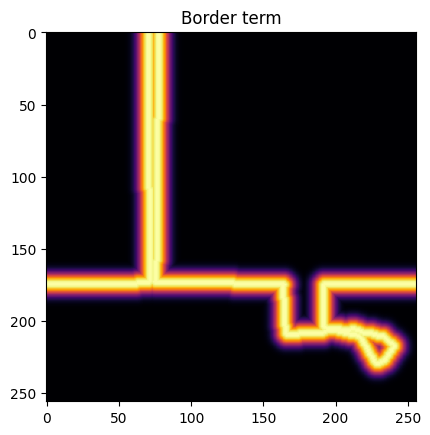

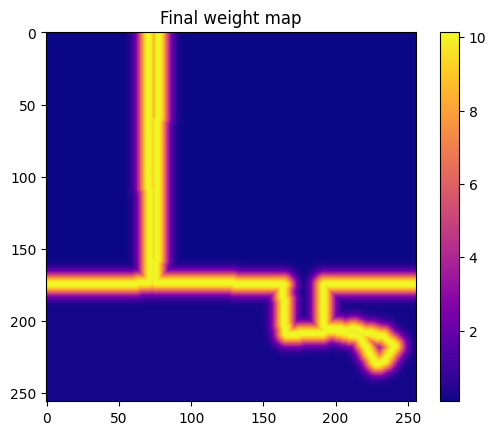

In [62]:
image, mask = dataset[4]
wc, border_term, weight_map = compute_weight_map_multiclass_changed(np.array(mask.squeeze()), 21)

print(weight_map.shape)
# plt.subplot(1, 3, 1)
plt.imshow(wc, cmap='viridis'); plt.title("Class balance $w_c$")
plt.show()

# plt.subplot(1, 3, 2)
plt.imshow(border_term, cmap='inferno'); plt.title("Border term")
plt.show()

# plt.subplot(1, 3, 3)
plt.imshow(weight_map, cmap='plasma'); plt.title("Final weight map")
plt.colorbar()
plt.show()

In [61]:
print(weight_map[50, 50])
print(weight_map[8, 1])
print(np.max(weight_map))

0.0906565710902214
0.0906565710902214
10.10030733793974
